### Installation of required packages

In [17]:
! pip install psutil pandas pynvml tqdm line_profiler matplotlib
! pip install pyahocorasick



### Imports and initialization

In [2]:
import multiprocessing
multiprocessing.set_start_method("spawn", force=True)

import time
import psutil
import logging
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor
from multiprocessing import cpu_count

# Matching algorithms to benchmark 

In [20]:
import ahocorasick

In [21]:
# Exemple de texte et motifs
text = "A" * 1000 + "B" * 500 + "ABCABCABC" * 100
patterns_single = "ABC"
patterns_multiple = ["A", "B", "C", "ABC", "BC", "AB"]



# Liste des fonctions à tester
from bench_functions import aho_corasick_search, boyer_moore_search, knuth_morris_pratt_search

TESTS = [
    (aho_corasick_search, (text, patterns_multiple)),  # note le tuple comme argument
    (boyer_moore_search, (text, patterns_single)),
    (knuth_morris_pratt_search, (text, patterns_single))
]


In [4]:
# Logging configuration: write execution details to a log file
logging.basicConfig(
    filename="benchmark.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

process = psutil.Process()

# Optional GPU memory tracking via NVIDIA NVML
#GPU_AVAILABLE = False
#try:
    #import pynvml
    #pynvml.nvmlInit()
    #handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    #GPU_AVAILABLE = True
#except Exception:
    #pass


### Single-run measurement utility

In [5]:
def run_once(fn, *args, **kwargs):
    """
    Execute a function once and collect basic timing and memory information.
    This is decorator-free to ensure functions remain pickleable.
    """
    t0 = time.perf_counter()
    result = fn(*args, **kwargs)
    t1 = time.perf_counter()

    mem = process.memory_info().rss / 1e6

    return {
        "time_seconds": t1 - t0,
        "memory_used_MB": mem,
        "result": result
    }

### Multi-run wrapper (manual loop)

In [11]:
def benchmark(fn, runs=5, args=()):
    """
    Run a function several times with positional arguments and compute average runtime.
    No decoration or wrapping done, to keep fn pickleable.
    """
    records = []
    for _ in range(runs):
        rec = run_once(fn, *args)  # dépaqueter le tuple
        records.append(rec)

    avg_time = sum(r["time_seconds"] for r in records) / len(records)

    return {
        "function": fn.__name__,
        "args": args,
        "time_mean": avg_time,
    }



### Test matrix

In [12]:
#TESTS = [
    #sort_dict, {"d": 200_000}),
    #(sort_dict, {"d": 1_000_000}),
    #(fibonacci_iter, {"n": 35}),
    #(fibonacci_iter, {"n": 45}),
#],

TESTS = [
    (aho_corasick_search, (text, patterns_multiple)),  # note le tuple comme argument
    (boyer_moore_search, (text, patterns_single)),
    (knuth_morris_pratt_search, (text, patterns_single))
]


### Sequential execution + progress bar

In [22]:
results_seq = []
for fn, params in TESTS:
    res = benchmark(fn, runs=5, args=params)  # <- args=params, no *
    logging.info(f"[SEQ] {res}")
    results_seq.append(res)

df_seq = pd.DataFrame(results_seq)
df_seq


,function,args,time_mean
0,aho_corasick_search,(AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,0.014522
1,boyer_moore_search,(AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,0.000517
2,knuth_morris_pratt_search,(AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,0.000315


### Parallel execution (CPU multiprocessing)

In [23]:
def run_single(param_tuple):
    """
    Wrapper called inside worker processes.
    Only passes raw call and returns a minimal serializable dict.
    """
    fn, params = param_tuple
    res = benchmark(fn, runs=5, **params)
    return res


In [28]:
def run_single(test):
    func, args = test  # args peut être un tuple ou un dict
    if isinstance(args, dict):
        args = (args.get("size", 0),)  # mettre en tuple
    elif not isinstance(args, tuple):
        args = (args,)  # transformer en tuple si un seul argument
    return func(*args)  # dépaqueter tous les arguments

# Exécution parallèle avec ThreadPoolExecutor (safe dans Jupyter)
with ThreadPoolExecutor(max_workers=cpu_count()) as exe:
    results = list(exe.map(run_single, TESTS))

# Création du DataFrame
df_parallel = pd.DataFrame({
    "function": [t[0].__name__ for t in TESTS],
    "argument": [t[1] for t in TESTS],
    "result": results
})

print(df_parallel)

print(df_parallel.columns)
print(df_parallel.dtypes)



                    function  \
0        aho_corasick_search   
1         boyer_moore_search   
2  knuth_morris_pratt_search   

                                            argument  \
0  (AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   
1  (AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   
2  (AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   

                                              result  
0  [(0, 0, A), (1, 1, A), (2, 2, A), (3, 3, A), (...  
1  [1500, 1503, 1506, 1509, 1512, 1515, 1518, 152...  
2  [1500, 1503, 1506, 1509, 1512, 1515, 1518, 152...  
Index(['function', 'argument', 'result'], dtype='object')
function    object
argument    object
result      object
dtype: object


### Line-level profiling (manual execution)

In [25]:
# Load the line profiler extension once at notebook start
#%load_ext line_profiler

# Example profiling call (change function as needed)
#%lprun -f sort_list sort_list(n=300_000)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


UsageError: Could not find module sort_list.
NameError: name 'sort_list' is not defined


### MEASURE OF EXEC TIME

In [29]:
def run_single_with_metrics(test):
    func, arg = test
    if isinstance(arg, dict):
        arg = arg.get("size", 0)
    
    proc = psutil.Process(os.getpid())
    cpu_start = psutil.cpu_percent(interval=None)
    mem_start = proc.memory_info().rss / (1024*1024)  # en MB

    import time
    start = time.time()
    result = func(arg)
    end = time.time()

    cpu_end = psutil.cpu_percent(interval=None)
    mem_end = proc.memory_info().rss / (1024*1024)  # en MB

    return {
        "result": result,
        "time_sec": end - start,
        "cpu_mean": cpu_end - cpu_start,
        "mem_mean_MB": mem_end - mem_start
    }


### DF CREATION

In [ ]:
with ThreadPoolExecutor(max_workers=cpu_count()) as exe:
    results = list(exe.map(run_single_with_metrics, TESTS))

df_parallel = pd.DataFrame({
    "function": [t[0].__name__ for t in TESTS],
    "argument": [t[1] for t in TESTS],
    "result": [r["result"] for r in results],
    "time_sec": [r["time_sec"] for r in results],
    "cpu_mean": [r["cpu_mean"] for r in results],
    "mem_mean_MB": [r["mem_mean_MB"] for r in results]
})

print(df_parallel.columns)



TypeError: aho_corasick_search() missing 1 required positional argument: 'patterns'

### Visualisation of results (boxplot + violin)

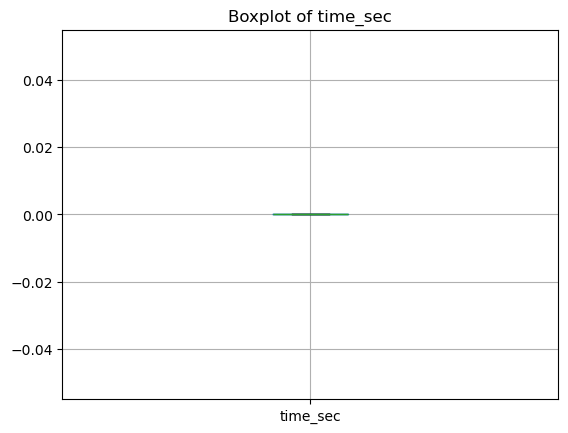

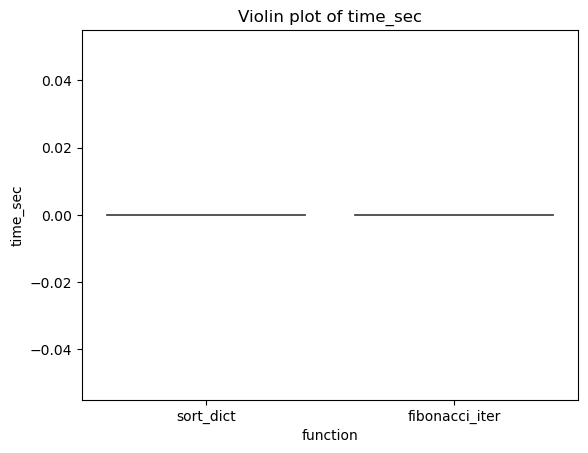

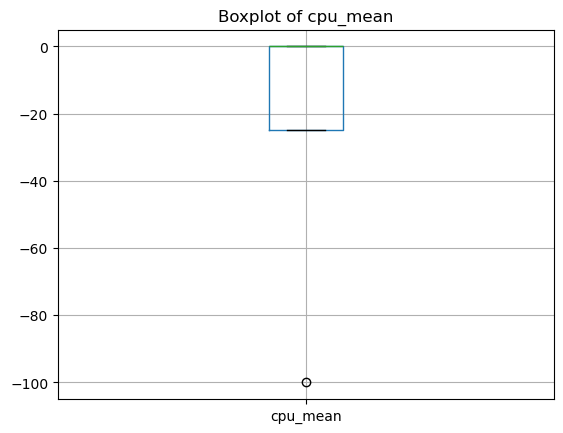

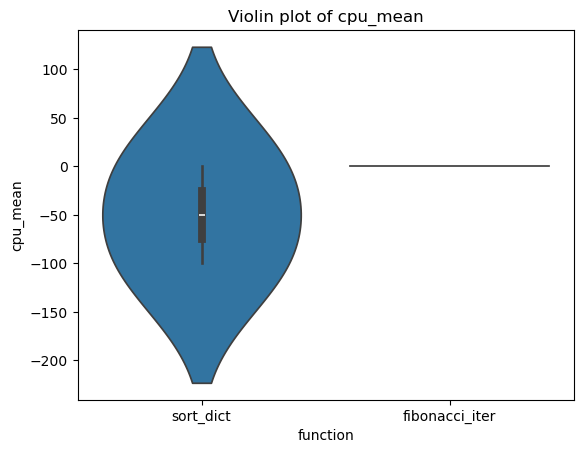

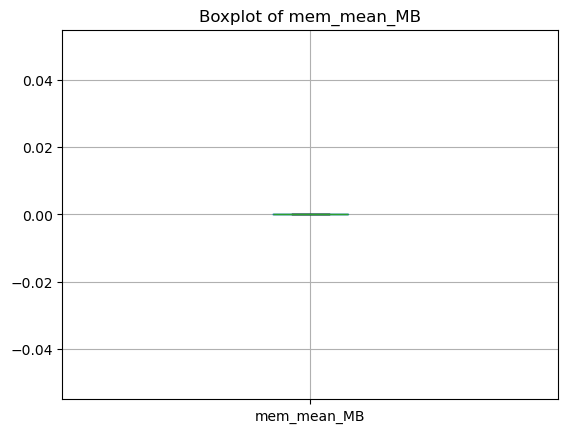

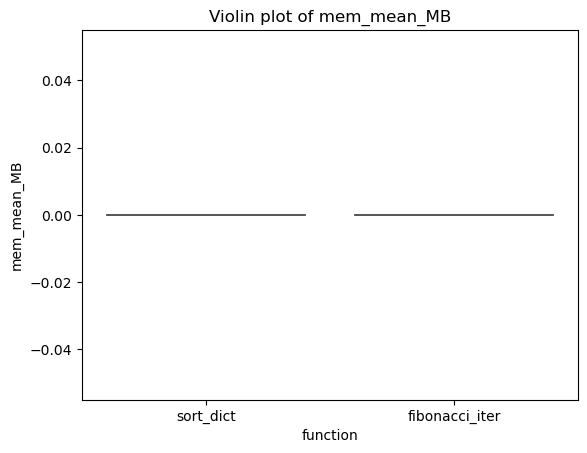

In [13]:
metrics = ["time_sec", "cpu_mean", "mem_mean_MB"]

for m in metrics:
    # Boxplot avec Pandas
    plt.figure()
    df_parallel.boxplot(column=[m])
    plt.title(f"Boxplot of {m}")
    plt.show()

    # Violin plot avec Seaborn
    plt.figure()
    sns.violinplot(x="function", y=m, data=df_parallel)
    plt.title(f"Violin plot of {m}")
    plt.show()


### Export results

In [14]:
df_seq.to_csv("bench_seq.csv", index=False)
df_parallel.to_csv("bench_parallel.csv", index=False)
print("Benchmark exports complete.")


Benchmark exports complete.
